In [472]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


# Height * Width * 3
# Mask Calculation : Checked 

def mask(img, x1, x2, y1, y2):
    """
    Takes an image and four coordinates, produces a mask with the same size as the image.

    Parameters:
        img (numpy.ndarray): Input image.
        x1, x2, y1, y2 (int): Coordinates defining the rectangle to be masked.

    Returns:
        numpy.ndarray: Mask with the specified region set to 0.
    """
    height, width = img.shape[:2]
    
    # Ensure coordinates are within image bounds
    x1 = max(0, min(x1, width - 1))
    x2 = max(0, min(x2, width))
    y1 = max(0, min(y1, height - 1))
    y2 = max(0, min(y2, height))

    # Create a mask with ones
    mask = np.ones((height, width), dtype=int)

    # Set the specified rectangle region to 0
    mask[y1:y2, x1:x2] = 0

    return mask



class Inpaint:

    @staticmethod
    def get_patch(center_pixel, img, patch_size):

        half_size = patch_size // 2

        center_x, center_y = center_pixel

        start_x = max(center_x - half_size, 0)
        end_x = min(center_x + half_size + 1, img.shape[1])

        start_y = max(center_y - half_size, 0)
        end_y = min(center_y + half_size + 1, img.shape[0])

        return img[start_y:end_y, start_x:end_x]

    @staticmethod
    def computeContours(image_):
        
        image = image_ * 255
        contours, hierarchy = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
        filtered_contours = []

        for contour in contours:
            new_contour = []    
            for point in contour:
                point = point[0]  # Extract the (x, y) coordinates
            
                # Skip points on the image borders
                if point[0] == 0 or point[1] == 0:
                    continue
                if point[0] == image.shape[1] - 1 or point[1] == image.shape[0] - 1:
                    continue
                
                new_contour.append(point)
            
            if new_contour:
                filtered_contours.append(np.array(new_contour, dtype=np.int32))

        return filtered_contours

    @staticmethod    
    def computeNormals(contour):

        normals = []

        for i in range(len(contour)):
            next_point = contour[(i + 1) % len(contour)]
            prev_point = contour[i - 1]

            dx = next_point[0] - prev_point[0]
            dy = next_point[1] - prev_point[1]

            normal = np.array([-dy, dx])
            normal = normal / (np.linalg.norm(normal) + 1e-8)

            normals.append(normal)
        return normals

    def __init__(self, img, mask, patch_size):

        self.finish = False
        self.patch_size = patch_size
        self.height, self.width = img.shape[:2]
        self.point = [-1, -1]

        self.img = img
        self.grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        self.rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        self.mask = mask

        self.contour = Inpaint.computeContours(self.mask)[0]
        self.normals = Inpaint.computeNormals(self.contour)

        self.confidence = np.zeros((self.height, self.width))
        self.confidence[self.mask == 0] = 1

        self.gradientX = cv.Sobel(self.grey_img, cv.CV_64F, 1, 0, ksize=3)
        self.gradientY = cv.Sobel(self.grey_img, cv.CV_64F, 0, 1, ksize=3)

        self.patchs = []

        for patch, x, y in self.getPatchs():
            self.patchs.append([patch, x, y])


    def getPatchs(self):

        h = w = self.patch_size

        for y in range(0, self.height - h + 1):
            for x in range(0, self.width - w + 1):
                
                patch = self.rgb_img[y:y+h, x:x+w]
                patch_mask = self.mask[y:y+h, x:x+w]

                if np.any(patch_mask == 1):
                    continue

                yield patch, x, y



    def calculateConfidence(self):

        contour_confidence = []

        for point in self.contour:
            patch = Inpaint.get_patch(point, self.confidence, self.patch_size)
            contour_confidence.append(np.mean(patch))

        return contour_confidence
    
    def calculateData(self):

        contour_data = []

        for i in range(len(self.contour)):

            point = self.contour[i]
            normal = self.normals[i]

            gradient = np.array([self.gradientX[point[1], point[0]], self.gradientY[point[1], point[0]]])
            isophate = np.array([gradient[1], -gradient[0]])
            isophate = isophate / (np.linalg.norm(isophate) + 1e-8)

            contour_data.append(np.abs(np.dot(isophate, normal)))

        return contour_data
    
    def update(self):
        self.contour = Inpaint.computeContours(self.mask * 255)

        if(len(self.contour) == 0):
            self.finish = True
            return
        
        self.contour = self.contour[0]


        self.normals = Inpaint.computeNormals(self.contour)

        self.grey_img = cv.cvtColor(self.rgb_img, cv.COLOR_BGR2GRAY)

        self.gradientX = cv.Sobel(self.grey_img, cv.CV_64F, 1, 0, ksize=3)
        self.gradientY = cv.Sobel(self.grey_img, cv.CV_64F, 0, 1, ksize=3)




    # Single inpainting iteration
    def inpaint(self):

        if(self.finish):
            return
        
        contour_confidence = self.calculateConfidence()
        contour_data = self.calculateData()

        contour_priority = np.array(contour_confidence) * np.array(contour_data)
        max_index = np.argmax(contour_priority)

        point = self.contour[max_index]

        target_patch = Inpaint.get_patch(point, self.rgb_img, self.patch_size)
        mask_patch = Inpaint.get_patch(point, self.mask, self.patch_size)

        mask_patch_expanded = cv.cvtColor(mask_patch, cv.COLOR_GRAY2RGB)         
        min_distance = np.inf
        min_x, min_y = -1, -1
        dist_x, dist_y = 0, 0

        for patch, x, y in self.patchs:

            patch = patch[:target_patch.shape[0], :target_patch.shape[1], :]

            diff = target_patch - patch
            diff = diff * (1 - mask_patch_expanded)

            distance = np.sum(diff ** 2)

            if distance < min_distance:
                min_distance = distance
                min_x, min_y = x, y
                dist_x, dist_y = target_patch.shape[1], target_patch.shape[0]

        

        best_patch = self.rgb_img[min_y:min_y+dist_y, min_x:min_x+dist_x, :]       
        self.fill = best_patch * mask_patch_expanded + target_patch * (1 - mask_patch_expanded)
        target_patch[:] = best_patch * mask_patch_expanded + target_patch * (1 - mask_patch_expanded)
        mask_patch[:] = 0


        # Update the Confidence s
        confidence_patch = Inpaint.get_patch(point, self.confidence, self.patch_size)
        confidence_patch[:] = contour_confidence[max_index]
    
        self.update()
        self.iterations -= 1



    def inpaint_all(self, iterations):
        self.iterations = iterations

        while(self.iterations > 0 and not self.finish):
            self.inpaint()
        
        return self.rgb_img

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()


In [ ]:
image = cv.imread('images/2.jpg')

mask_brg = mask(image, 390, 550, 350+35, 450+35)

mask_brg = np.uint8(mask_brg)

mask_brg[mask_brg == 0] = 5
mask_brg[mask_brg == 1] = 0
mask_brg[mask_brg == 5] = 1

inpaint = Inpaint(image, mask_brg, 21)

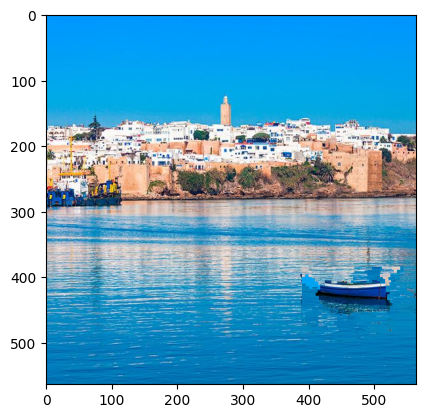

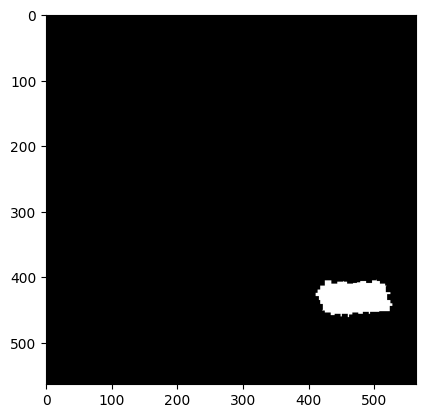

In [485]:
show_image(inpaint.rgb_img)
show_image(inpaint.mask)


In [483]:
inpaint.inpaint_all(1000)

show_image(inpaint.rgb_img)

print(inpaint.mask)

KeyboardInterrupt: 

In [ ]:
def test_contour(inpaint):
#     image = inpaint.rgb_img.copy()
#     contours = inpaint.contour

#     for point in contours:
#         image[point[1], point[0]] = [255, 255, 0]

#     show_image(image)

# def test_rgb(inpaint):
#     show_image(inpaint.rgb_img)

# def test_mask(inpaint):
#     show_image(inpaint.mask)

# def test_confidence(inpaint):
#     show_image(inpaint.confidence)

# def test_gradientX(inpaint):
#     show_image(inpaint.gradientX)

# def test_gradientY(inpaint):
#     show_image(inpaint.gradientY)

# def test_patchs(inpaint):
#     for patch, x, y in inpaint.patchs():
#         patch[:] = 0
#         show_image(inpaint.rgb_img)
